<a href="https://colab.research.google.com/github/MohammadRaziei/Deep-Learning-Course/blob/master/HW03/Q5/HW03_Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Data

In [28]:
!pip install wget
import wget, os
import numpy as np
import matplotlib.pyplot as plt

file_path = lambda x: '{}_32x32.mat'.format(x) # x : train, test, extra
file_url = lambda x: 'http://ufldl.stanford.edu/housenumbers/{}'.format(file_path(x)) # x : train, test, extra

for category in ['train', 'test']:
  if not os.path.exists(file_path(category)):
    wget.download(file_url(category))
print('ALL files is downloaded')

ALL files is downloaded


In [29]:
import scipy.io
train = scipy.io.loadmat(file_path('train'))
test = scipy.io.loadmat(file_path('test'))

Xtrain = train['X']
Ytrain = train['y']
#print(Xtrain.shape)           (32, 32, 3, 73257)
#print(Ytrain.shape)           (73257, 1)
Ytrain = Ytrain.flatten() % 10

Xtest = test['X']
Ytest = test['y']
#print(Xtest.shape)            (32, 32, 3, 26032)
#print(Ytest.shape)            (26032, 1)
Ytest = Ytest.flatten() % 10

Xtrain = (Xtrain.transpose(3,2,0,1) / 255).astype(np.float32)
Xtest = (Xtest.transpose(3,2,0,1) / 255).astype(np.float32)


### Visualize

In [30]:
import matplotlib.pyplot as plt
def plot_image(img):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    
def fix_image(img):
  return np.transpose(img, axes=(1,2,0))

def plot_image_fix(img):
  plot_image(fix_image(img))

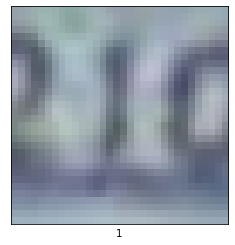

In [31]:
plot_image_fix(Xtest[2])
plt.xlabel(Ytest[2])
plt.show()

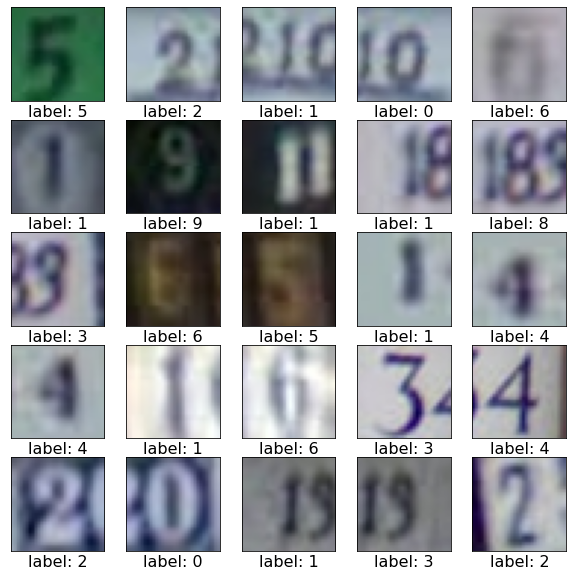

In [32]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plot_image_fix(Xtest[i])
    plt.xlabel('label: {}'.format(Ytest[i]), fontdict={'fontsize':16})
plt.show()


In [33]:
len(set(Ytrain))

10

## Configure device


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from sklearn.utils import shuffle


!pip install torchsummary
from torchsummary import summary

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print('GPU')
        return torch.device('cuda')
    else:
        print('CPU')
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [36]:
device = get_default_device()
device

CPU


device(type='cpu')

In [42]:
class CnnModel(nn.Module):
  def __init__(self, size, K):
    super(CnnModel, self).__init__()
    # define the layers
    # Input channels = 3, output channels = 20, filter size = (5,5)
    # padding=0 (valid mode), padding=4 (full mode), padding=2 (same mode)
    self.conv1 = nn.Conv2d(3, 20, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    # self.linear1 = nn.Linear(4900, size)
    self.linear1 = nn.Linear(50*8*8, size)
    self.linear2 = nn.Linear(size, K)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = to_device(x, device)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # x = x.view(-1, 4900) ## reshaping
    x = x.view(-1, 50*8*8) ## reshaping
    x = self.dropout(x)
    x = F.relu(self.linear1(x))
    x = self.dropout(x)
    x = self.linear2(x)
    return x
    # Note: no final softmax!
    # just like Tensorflow, it's included in cross-entropy function

In [43]:
class FitModel():
  def __init__(self, model):
    self.model = model
  
  def train(self, loss, optimizer, inputs, labels):
    # set the model to training mode
    # because dropout has 2 different modes!
    # we only perform dropout in train mode & not test mode
    self.model.train()
    
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)
    
    optimizer.zero_grad()
    
    # get output from the model, given the inputs
    logits = self.model.forward(inputs)
    
    # get loss for the predicted output
    cost = loss.forward(logits, labels)
    
    # get gradients w.r.t to parameters
    cost.backward()
    
    # update parameters
    optimizer.step()
    
    return cost.item()
  
  def test(self, loss, inputs, labels):
    self.model.eval()
    
    inputs = Variable(inputs, requires_grad=False)
    labels = Variable(labels, requires_grad=False)
    
    logits = self.model.forward(inputs)
    cost = loss.forward(logits, labels)
    
    return cost.item()
    
  def predict(self, inputs):
    self.model.eval()
    
    inputs = Variable(inputs, requires_grad=False)
    
    logits = self.model.forward(inputs)
    return logits.data.numpy().argmax(axis=1)

  def fit(self, Xtrain, Ytrain, Xtest, Ytest, training_epochs=5, batch_sz=500):
    N = Xtrain.shape[0]
    K = len(set(Ytrain))
    
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    Xtest, Ytest = shuffle(Xtest, Ytest)
    
    Xtest = Xtest[-10000:]
    Ytest = Ytest[-10000:]
    
    # convert the data arrays into torch tensors
    Xtrain = torch.from_numpy(Xtrain).float()
    Ytrain = torch.from_numpy(Ytrain).long()
    Xtest = torch.from_numpy(Xtest).float()
    Ytest = torch.from_numpy(Ytest).long()
    
    model = self.model
    
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters())
    
    n_batches = N // batch_sz
    
    train_costs = []
    test_costs = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(training_epochs):
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        train_c = self.train(loss, optimizer, Xbatch, Ybatch)
        
        if j % 20 == 0:
          train_costs.append(train_c)

          test_c = self.test(loss, Xtest, Ytest)
          test_costs.append(test_c)
          
          p_train = self.predict(Xbatch)
          p_test = self.predict(Xtest)
          
          acc_train = np.mean(p_train == Ybatch.numpy())
          train_accuracies.append(acc_train)

          acc_test = np.mean(p_test == Ytest.numpy())
          test_accuracies.append(acc_test)
          
          print("Epoch", (epoch+1), "Training Cost", "%.2f" % train_c, "Test cost", "%.2f" % test_c, "Training Acc", "%.2f" % acc_train, "Test Acc", "%.2f" % acc_test)

    self.history = {'loss': train_costs, 'accuracy': train_accuracies, 'val_loss': test_costs, 'val_accuracy' : test_accuracies}
    return self.history
    
  def plot_result(self, history=None):
    self_history = history if history is not None else self.history
    plt.plot(self_history['loss'], label='Training Cost')
    plt.plot(self_history['val_loss'], label='Validation Cost')
    plt.legend()
    plt.show()
    
    plt.plot(self_history['accuracy'], label='Training accuracy')
    plt.plot(self_history['val_accuracy'], label='Validation accuracy')
    plt.legend()
    plt.show()

In [44]:
model = CnnModel(size=500, K=10)
model = to_device(model, device)

In [40]:
# summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]           1,520
         MaxPool2d-2           [-1, 20, 14, 14]               0
            Conv2d-3           [-1, 50, 14, 14]          25,050
         MaxPool2d-4             [-1, 50, 7, 7]               0
           Dropout-5                 [-1, 4900]               0
            Linear-6                  [-1, 500]       2,450,500
           Dropout-7                  [-1, 500]               0
            Linear-8                   [-1, 10]           5,010
Total params: 2,482,080
Trainable params: 2,482,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 9.47
Estimated Total Size (MB): 9.77
----------------------------------------------------------------


In [45]:
model = FitModel(model)
model.fit(Xtrain, Ytrain, Xtest, Ytest) 

Epoch 1 Training Cost 2.31 Test cost 2.25 Training Acc 0.18 Test Acc 0.19
Epoch 1 Training Cost 2.24 Test cost 2.24 Training Acc 0.18 Test Acc 0.19
Epoch 1 Training Cost 2.23 Test cost 2.21 Training Acc 0.19 Test Acc 0.19
Epoch 1 Training Cost 2.18 Test cost 2.16 Training Acc 0.17 Test Acc 0.20
Epoch 1 Training Cost 1.94 Test cost 1.91 Training Acc 0.32 Test Acc 0.32
Epoch 1 Training Cost 1.50 Test cost 1.40 Training Acc 0.57 Test Acc 0.57
Epoch 1 Training Cost 1.09 Test cost 1.09 Training Acc 0.70 Test Acc 0.67
Epoch 1 Training Cost 0.97 Test cost 0.90 Training Acc 0.72 Test Acc 0.74
Epoch 2 Training Cost 0.88 Test cost 0.82 Training Acc 0.75 Test Acc 0.76
Epoch 2 Training Cost 0.93 Test cost 0.73 Training Acc 0.77 Test Acc 0.79
Epoch 2 Training Cost 0.74 Test cost 0.68 Training Acc 0.83 Test Acc 0.81
Epoch 2 Training Cost 0.65 Test cost 0.63 Training Acc 0.83 Test Acc 0.82
Epoch 2 Training Cost 0.68 Test cost 0.62 Training Acc 0.83 Test Acc 0.82
Epoch 2 Training Cost 0.65 Test cost 0

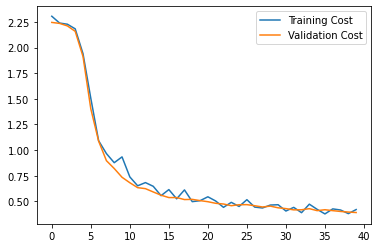

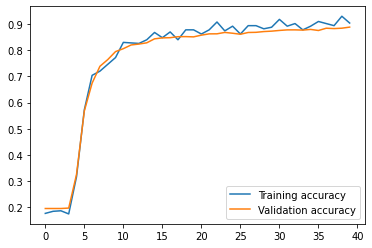

In [46]:
model.plot_result()